In [ ]:
import time
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

sns.set_context("talk")

Train shape: (37698, 768)
Test shape : (9425, 768)
C values to try: [1.00000000e-02 3.51119173e-02 1.23284674e-01 4.32876128e-01
 1.51991108e+00 5.33669923e+00 1.87381742e+01 6.57933225e+01
 2.31012970e+02 8.11130831e+02 2.84803587e+03 1.00000000e+04]
CV splits: 5
Total fits: 12 * 5 = 60
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START C=0.01.....................................................
[CV 1/5; 1/12] END ..C=0.01;, score=(train=0.826, test=0.814) total time=  29.9s
[CV 2/5; 1/12] START C=0.01.....................................................
[CV 2/5; 1/12] END ..C=0.01;, score=(train=0.825, test=0.815) total time=  29.3s
[CV 3/5; 1/12] START C=0.01.....................................................
[CV 3/5; 1/12] END ..C=0.01;, score=(train=0.825, test=0.825) total time=  29.7s
[CV 4/5; 1/12] START C=0.01.....................................................
[CV 4/5; 1/12] END ..C=0.01;, score=(train=0.825, test=0.823) total time=  30.2s
[C

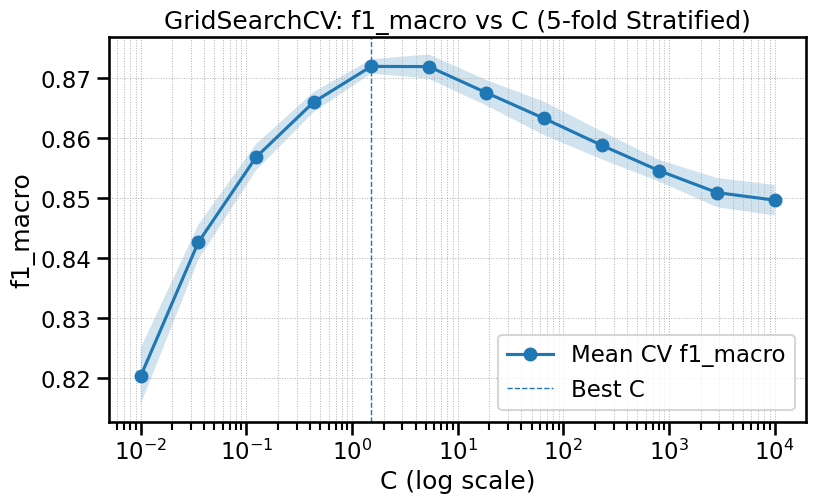

In [ ]:
# =========================
# 1) Load embeddings + labels
# =========================
DATA_EMBEDDING_DIR = "/content/drive/MyDrive/Colab Notebooks/models/inputs"
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/models/outputs"
X_train = np.load(f"{DATA_EMBEDDING_DIR}/X_train_emb.npy")
y_train = np.load(f"{DATA_EMBEDDING_DIR}/y_train.npy")
X_test = np.load(f"{DATA_EMBEDDING_DIR}/X_test_emb.npy")
y_test = np.load(f"{DATA_EMBEDDING_DIR}/y_test.npy")

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# =========================
# 2) Pipeline: Scaling + LinearSVC
# =========================
pipe = LinearSVC(
        class_weight="balanced",
        random_state=42,
    )

# =========================
# 3) GridSearchCV
# =========================
C_values = np.logspace(-2, 4, 12)
param_grid = {"C": C_values} # Changed from {"svm__C": C_values} to {"C": C_values}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_splits = cv.get_n_splits(X_train, y_train)

print("C values to try:", C_values)
print(f"CV splits: {n_splits}")
print(f"Total fits: {len(C_values)} * {n_splits} = {len(C_values) * n_splits}")

N_JOBS = 1

t0 = time.time()
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=N_JOBS,
    refit=True,
    verbose=10,
    return_train_score=True,
    error_score="raise",
 )

grid.fit(X_train, y_train)
print(f"Elapsed: {time.time() - t0:.1f}s")

print("Best params:", grid.best_params_)
print("Best CV f1_macro:", f"{grid.best_score_:.4f}")

# =========================
# 4) Plot: CV score vs C
# =========================
results = grid.cv_results_
Cs = results["param_C"].data.astype(float) # Changed from "param_svm__C" to "param_C"
mean_test = results["mean_test_score"]
std_test = results["std_test_score"]

order = np.argsort(Cs)
Cs, mean_test, std_test = Cs[order], mean_test[order], std_test[order]

plt.figure(figsize=(9, 5))
plt.semilogx(Cs, mean_test, marker="o", label="Mean CV f1_macro")
plt.fill_between(Cs, mean_test - std_test, mean_test + std_test, alpha=0.2)
plt.axvline(grid.best_params_["C"], linestyle="--", linewidth=1, label="Best C") # Changed from "svm__C" to "C"
plt.title("GridSearchCV: f1_macro vs C (5-fold Stratified)")
plt.xlabel("C (log scale)")
plt.ylabel("f1_macro")
plt.grid(True, which="both", linestyle=":", linewidth=0.7)
plt.legend()
plt.show()

Test Accuracy : 0.8758
Test F1-macro : 0.8756

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       730
           1       0.81      0.80      0.81       716
           2       0.85      0.88      0.87       714
           3       0.95      0.94      0.95       734
           4       0.81      0.84      0.82       733
           5       0.88      0.86      0.87       710
           6       0.96      0.96      0.96       735
           7       0.80      0.88      0.84       714
           8       0.87      0.85      0.86       733
           9       0.97      0.97      0.97       726
          10       0.81      0.77      0.79       731
          11       0.93      0.95      0.94       721
          12       0.79      0.78      0.79       728

    accuracy                           0.88      9425
   macro avg       0.88      0.88      0.88      9425
weighted avg       0.88      0.88      0.88      9425



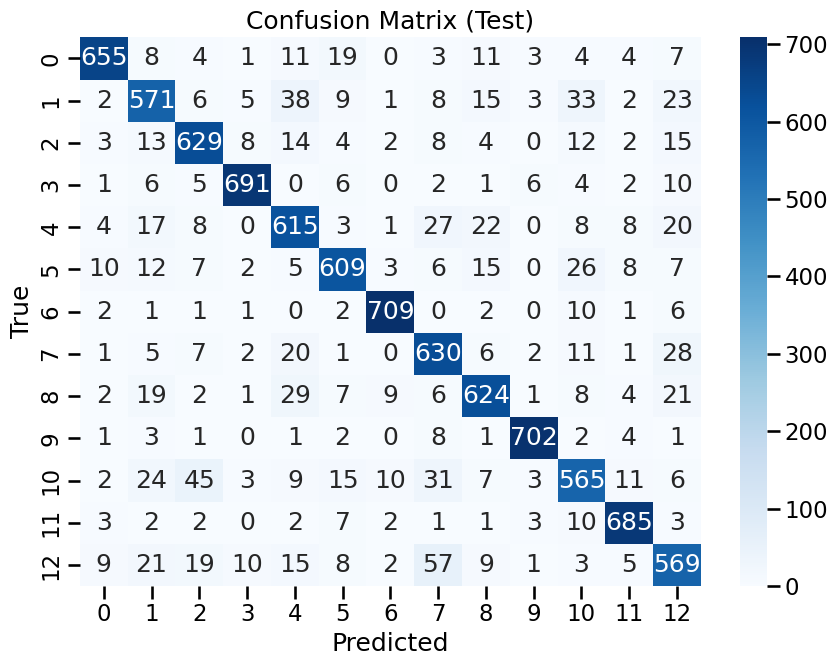

>> Saved best model to: /content/drive/MyDrive/Colab Notebooks/models/outputs/linear_svc_phobert.joblib


In [ ]:
# =========================
# 5) Evaluate best model on TEST + Confusion Matrix
# =========================
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print(f"Test Accuracy : {acc:.4f}")
print(f"Test F1-macro : {f1:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
labels = np.unique(np.concatenate([y_test, y_pred]))
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
 )
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# =========================
# 6) Save best model
# =========================
out_path = f"{SAVE_DIR}/linear_svc_phobert.joblib"
joblib.dump(best_model, out_path)
print(f">> Saved best model to: {out_path}")

In [3]:
SAVE_MODEL_DIR = "models/svm_opt"
SAVE_EMBEDDINGS_DIR = "models/embeddings_train_test"

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


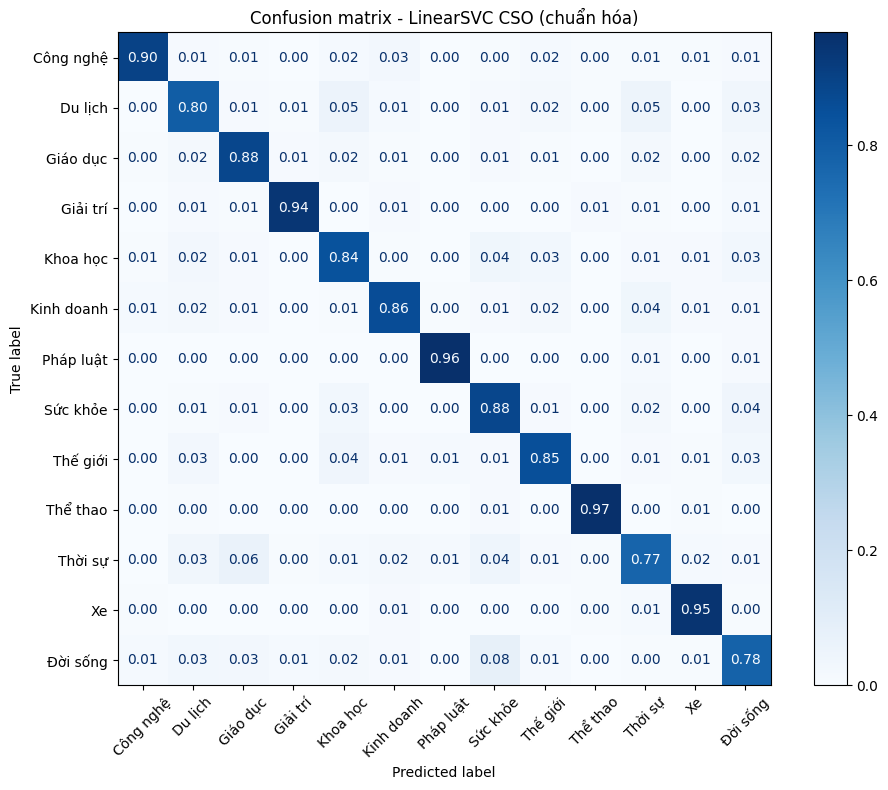

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


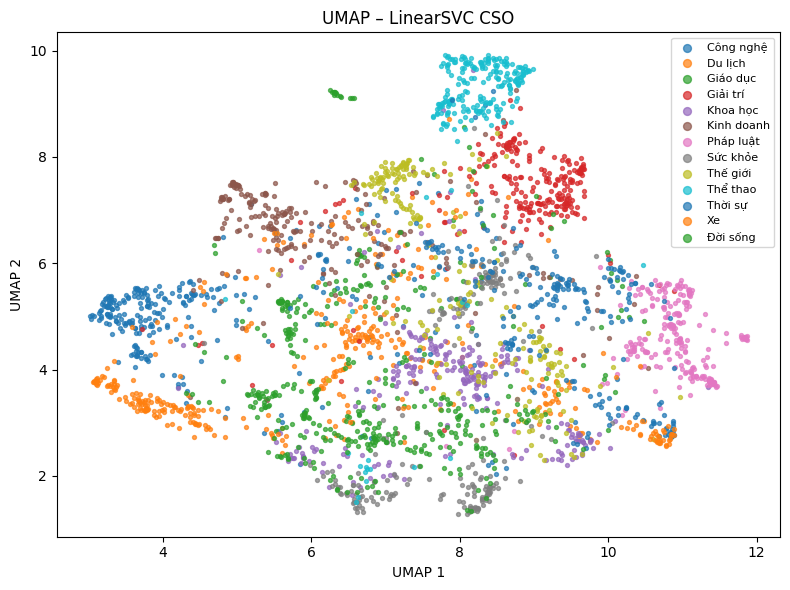

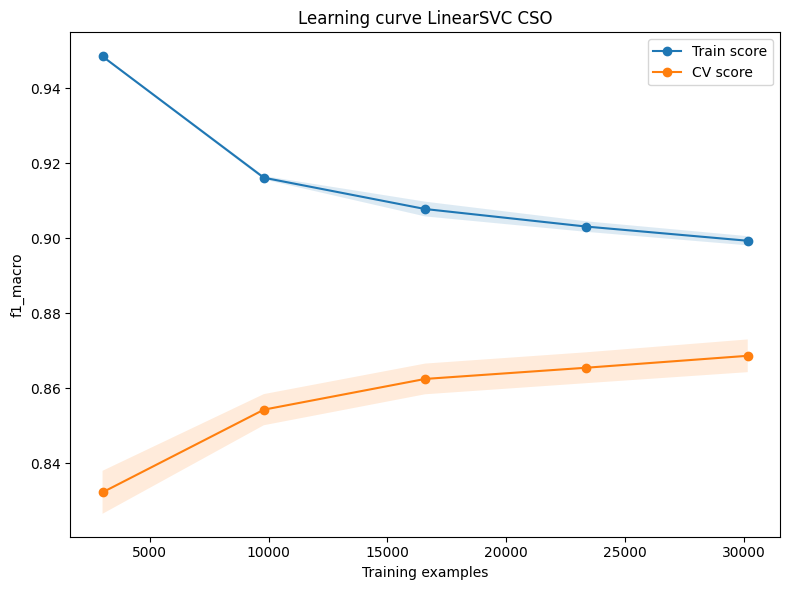

In [4]:
# ================== ĐÁNH GIÁ & TRỰC QUAN HÓA MODEL LINEAR ==================
import joblib
import numpy as np
from phobert_svm_pipeline import (    
    evaluate_confusion_matrix, plot_umap_embeddings,
    plot_learning_curve_svm
)
clf = joblib.load(f"{SAVE_MODEL_DIR}/linear_svc_grid.joblib")

X_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_train_emb.npy")
y_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_train.npy")
X_test  = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_test_emb.npy")
y_test_num  = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_test.npy")

LABEL_NAMES = [
    "Công nghệ",     # 0
    "Du lịch",       # 1
    "Giáo dục",      # 2
    "Giải trí",      # 3
    "Khoa học",      # 4
    "Kinh doanh",    # 5
    "Pháp luật",     # 6
    "Sức khỏe",      # 7
    "Thế giới",      # 8
    "Thể thao",      # 9
    "Thời sự",       # 10
    "Xe",            # 11
    "Đời sống",      # 12
]

# 1) Confusion matrix (dùng EMBEDDING đã lưu -> không embed lại)
evaluate_confusion_matrix(
    clf,
    X_emb=X_test,
    y_true_labels=y_test_num,
    normalize=True,
    title="Confusion matrix - LinearSVC CSO",
    label_names=LABEL_NAMES
)

# 2) UMAP (dùng EMBEDDING đã lưu)
# Lưu ý: cần cài umap-learn trước khi chạy:  pip install umap-learn
plot_umap_embeddings(
    X_emb=X_test,
    y_int=y_test_num,
    label_names=LABEL_NAMES,
    max_points=3000,
    title="UMAP – LinearSVC CSO"
)

# 3) Learning curve (trên EMBEDDING train đã lưu)
plot_learning_curve_svm(
    clf,
    X_emb=X_train,
    y_labels=y_train,
    scoring="f1_macro",
    title="Learning curve LinearSVC CSO"
)